# ***Recurrent Neural Networks (RNNs)***

## ***Part 1: Understanding Sequential Data with the d2l Library***

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l # pip install d2l

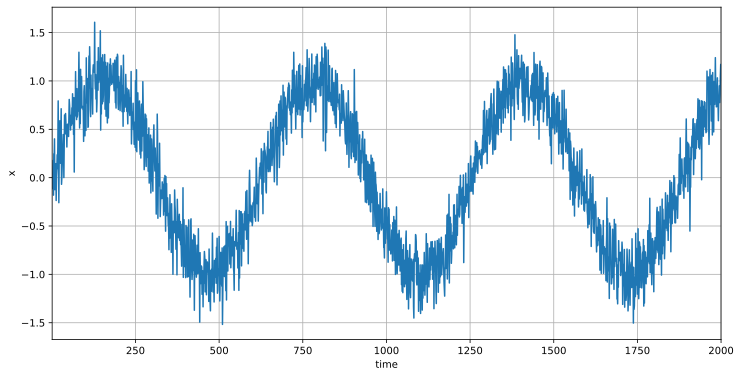

In [2]:
# These following examples showcase sequential data modelling use simple linear regression.

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=2000, num_train=600, tau=3):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 2000], figsize=(12, 6))

In [3]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

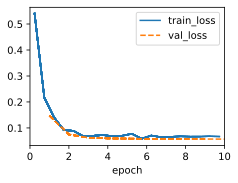

In [4]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

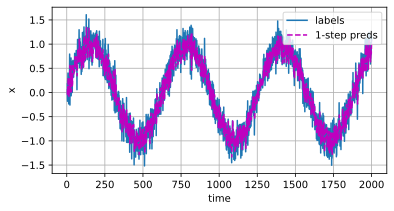

In [5]:
# one step ahead prediction

onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

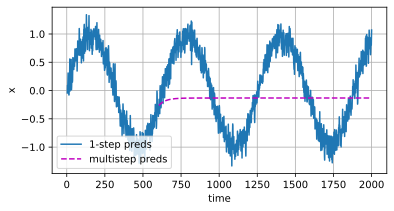

In [6]:
# Multiple steps ahead into the future: Epic fail edition:

multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

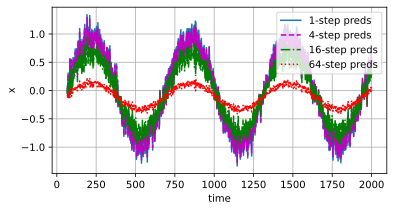

In [7]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))



### Book Exercises

Improve the model in the experiment of this section.

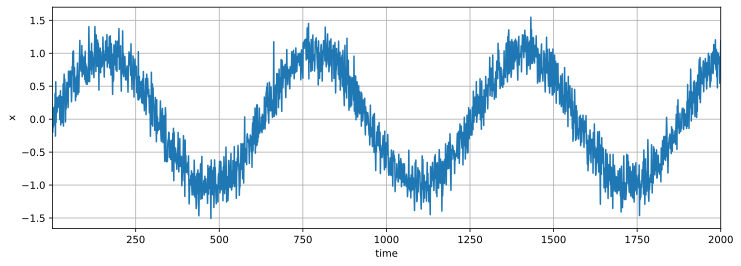

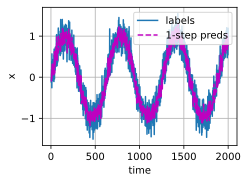

In [8]:
# Define data class with tau=3
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=2000, num_train=600, tau=3):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

# Create dataset
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 2000], figsize=(12, 4))

# MLP model using d2l.Module (with forward, loss, and optimizer)
class MLP(d2l.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01)

# Instantiate model and trainer
model = MLP(input_dim=data.tau)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# One-step prediction
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))


<br>

The predictions track the underlying signal very well, despite the noise

 - This indicates that the MLP successfully learned the temporal pattern from just 3 past values (tau=3)

 - This shows the MLP captures the temporal dynamics better than a linear model

<br>

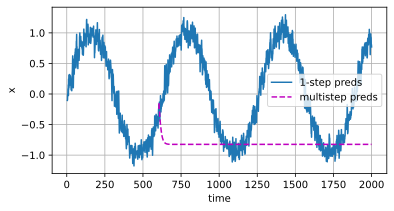

In [9]:
# Multiple steps ahead into the future: Epic fail edition:

multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

<br>

This plot shows how error compounds as predictions recursively feed back into the model — and we see the “epic fail” effect: the prediction flattens out after some steps That’s very common in autoregressive models when noise and drift aren’t corrected by ground truth

<br>

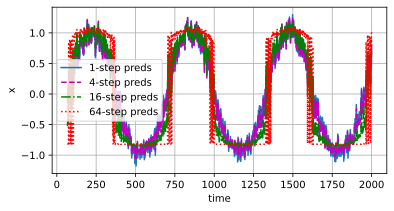

In [10]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

<br>

This plot shows:

- 1-step is nearly perfect

- 4-step & 16-step remain usable

- 64-step starts to diverge with visible loss of resolution (but still holds the general wave)


This mimics what we expect in real-world time series models: the longer you look ahead, the higher the uncertainty

<br>

Incorporate more than the past four observations? How many do you really need?

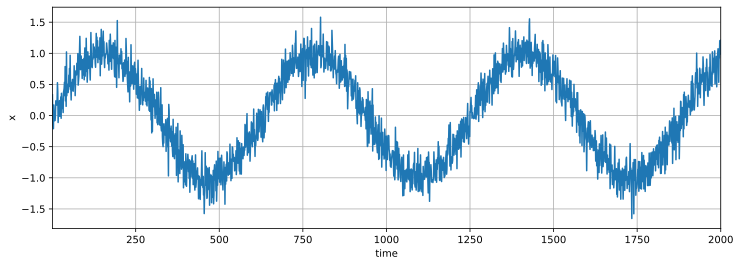

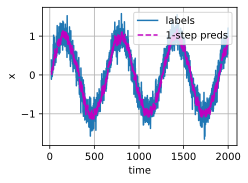

In [11]:
# Define data class with tau=3
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=2000, num_train=600, tau=16):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

# Create dataset
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 2000], figsize=(12, 4))

# MLP model using d2l.Module (with forward, loss, and optimizer)
class MLP(d2l.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01)

# Instantiate model and trainer
model = MLP(input_dim=data.tau)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# One-step prediction
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))


<br>

Increasing the history length (tau=16) seems to have improved prediction stability and accuracy, especially in the more complex or noisy parts of the curve

- Increasing the number of past observations gave the model more context, allowing it to learn better temporal dependencies

- Even with simple architectures like an MLP, this additional memory can significantly improve performance — especially for autoregressive time series

<br>

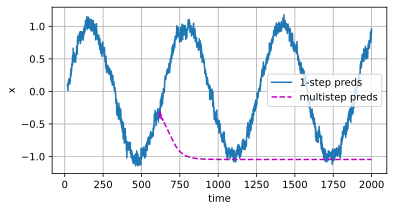

In [12]:
# Multiple steps ahead into the future: Epic fail edition:

multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

<br>

This plot shows:

-  1-step predictions (blue) stay strong

- The multi-step predictions (purple dashed) gradually drift and flatten again, but less severely than in Exercise 1

- This confirms that increasing tau gives better short-term stability, even in recursive forecasting

<br>

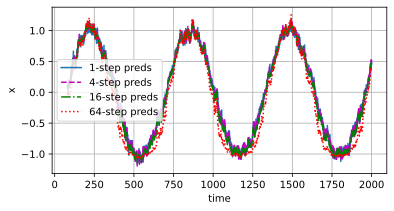

In [13]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

<br>

This plot shows:

- 1-step: Still nearly perfect

- 4-step & 16-step: Much better than when tau=3

- 64-step: Some expected noise and drift, but overall much smoother and accurate compared to Exercise 1

<br>

How many past observations would you need if there was no noise? 


If the data were noise-free and generated deterministically (e.g., a sine wave), the minimum number of past observations needed would match the true order of the underlying process. For a sine wave, often two past values suffice due to its second-order recurrence

<br>

An investor wants to find a good security to buy. They look at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?

1. Overfitting: Past performance does not guarantee future results

2. Non-stationarity: Market conditions change, violating the assumption that past patterns repeat

3. Spurious correlations: Past returns may correlate with noise or random fluctuations

4. No causality: Returns are influenced by external factors (e.g., news), not just their own history

<br>

Does causality also apply to text? To which extent?


- Yes, but differently

    - In language, causality is directional in the form of syntax and semantics (e.g., grammar enforces word order)

    - However, text is not causal in a scientific sense – future words do not cause past ones

    - Language models (like RNNs or transformers) treat previous tokens as the "cause" of future ones in prediction, a useful modelling assumption but not always a true causal relationship

<br>

Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.

- In speech recognition or financial time series

    - Observed data (e.g., speech waveforms) are driven by latent states (e.g., phonemes or market regimes)

    - Latent autoregressive models like Hidden Markov Models (HMMs) or state-space RNNs can capture this, where the observed data depends on both past latent states and observations

<br>